In [1]:
 !git clone https://github.com/chrisyeh96/africa_poverty_clean.git

Cloning into 'africa_poverty_clean'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 372 (delta 237), reused 281 (delta 146), pack-reused 0
Receiving objects: 100% (372/372), 3.56 MiB | 992.00 KiB/s, done.
Resolving deltas: 100% (237/237), done.


In [2]:
!pwd

/home/aimsg/PycharmProjects/demo/africa_poverty_clean


In [3]:
!bash ./4_download_model_checkpoints.sh

bash: ./4_download_model_checkpoints.sh: No such file or directory


## Pre-requisites

Before running this notebook, you should have already used the `extract_features.py` script to extract features from models trained on DHS data. You should have the following structure under the `outputs/` directory:

```
dhs_ooc/
    DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001/
        features.npz
    ...
    DHS_OOC_E_rgb_same_b64_fc001_conv001_lr0001/
        features.npz
dhs_incountry/
    DHS_Incountry_A_ms_samescaled_b64_fc01_conv01_lr001/
        features.npz
    ...
    DHS_Incountry_E_nl_random_b64_fc01_conv01_lr001/
        features.npz
transfer/
    transfer_nlcenter_ms_b64_fc001_conv001_lr0001/
        features.npz
    transfer_nlcenter_rgb_b64_fc001_conv001_lr0001/
        features.npz
        

TODO: update when keep-frac models are added
```

## Instructions

This notebook essentially performs fine-tuning of the final-layer of the Resnet-18 models. However, instead of directly fine-tuning the Resnet-18 models in TensorFlow, we train ridge-regression models using the extracted features. We take this approach for two reasons:

1. It is easier to perform leave-one-group-out ("logo") cross-validated ridge regression using scikit-learn, as opposed to TensorFlow. For out-of-country (OOC) experiments, the left-out group is the test country. For in-country experiments, the left-out group is the test split.
2. We can concatenate the 512-dim features from the RGB/MS CNN models with the 512-dim features from the NL CNN models to form a larger 1024-dim feature vector capturing RGB/MS + NL imagery information. We do this instead of training a CNN with the MS+NL imagery stacked together as an input because we found it to result in better performance.

Because of the extensive cross-validation, each "logo" CV run may take ~2-4 hours. In total, this notebook may take upwards of 15 hours to complete.

After you complete this notebook, use the `model_analysis/dhs_ooc.ipynb` and `model_analysis/dhs_incountry.ipynb` (TODO) notebooks to analyze the final performance of the fine-tuned Resnet-18 models.

In [4]:
#!cp -R '/content/africa_poverty_clean' '/content/Baselines'

In [5]:
#!cp -R '/content/drive/MyDrive/dhs_tfrecords' '/content/africa_poverty_clean'

## Imports and Constants

In [1]:
#%cd '../'
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
%cd ./africa_poverty_clean


/home/aimsg/PycharmProjects/demo/africa_poverty_clean/africa_poverty_clean


In [2]:
!pip install geopandas jupyter_contrib_nbextensions jupyterlab matplotlib  mypy  numpy pandas pillow scikit-learn scipy seaborn tqdm tensorflow
#!pip install tensorflow-gpu==1.15  # for GPU

You should consider upgrading via the '/home/aimsg/PycharmProjects/demo/demo/bin/python -m pip install --upgrade pip' command.


In [3]:
from __future__ import annotations

from collections.abc import Iterable
import os
import pickle
import numpy as np
import pandas as pd
from batchers import dataset_constants_buildings
from models.linear_model import ridge_cv
from utils.utils import load_npz
#from utils.general import load_npz

#Install dependencies 

In [ ]:
!pip install cartopy  earthengine-api==0.1.236 flake8==3.9.1 geopandas==0.7.0 jupyter_contrib_nbextensions==0.5.1 jupyterlab==3.0.15 matplotlib==3.4.1  mypy==0.812  numpy pandas==1.2.4 pillow==8.1.2 scikit-learn==0.24.2 scipy==1.6.3 seaborn==0.10.1 tqdm==4.60.0 tensorflow==1.15.*
#!pip install tensorflow-gpu==1.15  # for GPU

  Using cached Cartopy-0.20.1.tar.gz (10.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  ERROR: Command errored out with exit status 1:
   command: /home/aimsg/PycharmProjects/demo/demo/bin/python /home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmpzc0rqb_t
       cwd: /tmp/pip-install-5ik40nz0/cartopy_7ef6007fe9e649b48654971c1b82a287
  Complete output (3 lines):
  setup.py:120: UserWarning: Unable to determine GEOS version. Ensure you have 3.7.2 or later installed, or installation may fail.
    '.'.join(str(v) for v in GEOS_MIN_VERSION), ))
  Proj version 5.2.0 is installed, but cartopy requires at least version 8.0.0.
  ----------------------------------------
  Using cached Cartopy-0.20.0.tar.gz (10.8 MB)
  Installing build dependencies ... \

#Start

In [4]:
FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']
OUTPUTS_ROOT_DIR = 'outputs'
COUNTRIES = dataset_constants_buildings.DHS_COUNTRIES

KEEPS = [0.05, 0.1, 0.25, 0.5]
SEEDS = [123, 456, 789]



In [5]:
MODEL_DIRS = {
    'resnet_ms_A':'DHS_OOC_A_building_attn_pretrained_355P100_b32_fce-05_conve-05_lre-05_crop355',
    'resnet_ms_B':'DHS_OOC_B_building_attn_pretrained_355P100_b32_fce-05_conve-05_lre-05_crop355',
    'resnet_ms_C':'DHS_OOC_C_building_attn_pretrained_attn_355P100_b32_fce-05_conve-05_lr0001_crop355',
    'resnet_ms_D':'DHS_OOC_D_building_attn_pretrained_355P100_b32_fce-05_conve-05_lre-05_crop355',
    'resnet_ms_E':'DHS_OOC_E_building_attn_pretrained_355P100_b32_fce-05_conve-05_lre-05_crop355',
    # Build=>
      'resnet_nl_A':'DHS_OOC_A_NL_attn_pretrained_355P100_b32_fce-05_conve-05_lr0000000000000004e-05_crop355',
   'resnet_nl_B': 'DHS_OOC_C_NL_attn_pretrained_355P100_b32_fce-05_conve-05_lr0000000000000004e-05_crop355',
    'resnet_nl_C':'DHS_OOC_NL_attn_pretrained_355P100_b32_fc0003_conv0003_lre-05_crop355_foldB',
    'resnet_nl_D':'DHS_OOC_D_NL_attn_pretrained_355P100_b32_fce-05_conve-05_lr0000000000000004e-05_crop355',
   'resnet_nl_E': 'DHS_OOC_E_NL_attn_pretrained_355P100_b32_fc1_conv1_lr0001_crop355',
    # OOC models
   # 'resnet_ms_A': 'DHS_OOC_A_ms_samescaled_b16_fc01_conv01_lr0001',
   # 'resnet_ms_B': 'DHS_OOC_B_ms_samescaled_b32_fc001_conv001_lr0001',
   # 'resnet_ms_C': 'DHS_OOC_C_ms_samescaled_b32_fc001_conv001_lr001',
  #  'resnet_ms_D': 'DHS_OOC_D_ms_samescaled_b32_fc001_conv001_lr01',
  # 'resnet_ms_E': 'DHS_OOC_E_ms_random_b32_fc01_conv01_lr001',
    # 'resnet_ms_A':'DHS_OOC_A_NL_pretrained_attnP224stride140_b32_fce-05_conve-05_lr0001_crop511',

     # 'resnet_ms_B':'DHS_OOC_B_NL_new_attn_pretrained_P224_stride140_b32_fce-05_conve-05_lr0001_crop511',
      #'resnet_ms_C':'DHS_OOC_C_NL_pretrained_attnP224stride140_b32_fce-05_conve-05_lr0001_crop511',
      #'resnet_ms_D':'DHS_OOC_D_NL_pretrained_attnP224stride140_b32_fce-05_conve-05_lr0001_crop511',
      #'resnet_ms_E':'DHS_OOC_E_NL_pretrained_attnP224stride140_b32_fce-05_conve-05_lr0001_crop511',
   # 'resnet_ms_A': 'DHS_OOC_A_ms_samescaled_keep0.25_seed456_b64_fc01_conv01_lr001',
   # 'resnet_ms_B': 'DHS_OOC_B_ms_samescaled_keep0.25_seed456_b64_fc001_conv001_lr0001',
   # 'resnet_ms_C': 'DHS_OOC_C_ms_samescaled_keep0.25_seed456_b64_fc001_conv001_lr001',
   # 'resnet_ms_D': 'DHS_OOC_D_ms_samescaled_keep0.25_seed456_b64_fc001_conv001_lr01',
   # 'resnet_ms_E': 'DHS_OOC_E_ms_samescaled_keep0.25_seed456_b64_fc01_conv01_lr001',
   # 'resnet_ms_A': 'DHS_OOC_A_ms_samescaled_keep0.25_seed456_b64_fc01_conv01_lr0001',
    #'resnet_ms_B': 'DHS_OOC_B_ms_samescaled_keep0.25_seed456_b64_fc001_conv001_lr0001/',
    #'resnet_ms_C': 'DHS_OOC_C_ms_samescaled_keep0.25_seed456_b64_fc001_conv001_lr001/',
    #'resnet_ms_D': 'DHS_OOC_D_ms_samescaled_keep0.25_seed456_b64_fc001_conv001_lr01/',
    #'resnet_ms_E': 'DHS_OOC_E_ms_samescaled_keep0.25_seed456_b64_fc01_conv01_lr001/',
   # 'resnet_nl_A':  'DHS_OOC_A_NL_pretrained_attnP224stride140_uniform_b32_fce-05_conve-05_lr0001_crop511',
   #  'resnet_nl_B':   'DHS_OOC_B_NL_new_attn_pretrained_P224_uniform_stride140_b32_fce-05_conve-05_lr0001_crop511',
   #  'resnet_nl_C':    'DHS_OOC_C_NL_pretrained_attnP224stride140_uniform_b32_fce-05_conve-05_lr0001_crop511',
   #  'resnet_nl_D':  'DHS_OOC_D_NL_pretrained_attnP224stride140_uniform_b32_fce-05_conve-05_lr0001_crop511',
   #   'resnet_nl_E':'DHS_OOC_E_NL_pretrained_attnP224stride140_uniform_b32_fce-05_conve-05_lr0001_crop511',


     # 'resnet_ms_A':'DHS_OOC_A_NL_new_no_attn_P224_b32_fce-05_conve-05_lr0001_crop0',
  #'resnet_ms_B':'DHS_OOC_B_NL_new_no_attn_P224_b32_fce-05_conve-05_lr0001_crop0',
   #'resnet_ms_C':'DHS_OOC_C_NL_new_no_attn_P224_b32_fce-05_conve-05_lr0001_crop0',
   #'resnet_ms_D':'DHS_OOC_D_NL_new_no_attn_P224_b32_fce-05_conve-05_lr0001_crop0',
   # 'resnet_ms_E':'DHS_OOC_E_NL_new_no_attn_P224_b32_fce-05_conve-05_lr0001_crop0',
            #   'resnet_nl_A'  :'DHS_OOC_A_NL_Noise_validation_offsetCent_test_b64_fc_conv_lr0001_crop224',
     #'resnet_nl_B'  :'DHS_OOC_B_NL_Noise_validation_offsetCent_test_b64_fc_conv_lr0001_crop224',
     #'resnet_nl_C'  :'DHS_OOC_C_NL_Noise_validation_offsetCent_test_b64_fc_conv_lr0001_crop224',
     #'resnet_nl_D'  :'DHS_OOC_D_NL_Noise_validation_offsetCent_test_b64_fc_conv_lr0001_crop224',
     #   'resnet_nl_E'  :'DHS_OOC_E_NL_Noise_validation_offsetCent_test_b64_fc_conv_lr0001_crop224',
   #'resnet_nl_A'  :'DHS_OOC_A_NL_Noise_cent_nooffset_attn_b64_fc01_conv01_lr0001_crop0',
   #  'resnet_nl_B'  :'DHS_OOC_B_NL_Noise_cent_nooffset_attn_b64_fc01_conv01_lr0001_crop0',
    # 'resnet_nl_C'  :'DHS_OOC_C_NL_Noise_cent_nooffset_attn_b64_fc01_conv01_lr0001_crop0',
     #'resnet_nl_D'  :'DHS_OOC_D_NL_Noise_cent_nooffset_attn_b64_fc01_conv01_lr0001_crop0',
     #   'resnet_nl_E'  :'DHS_OOC_E_NL_Noise_cent_nooffset_attn_b64_fc01_conv01_lr0001_crop0',

 #   'resnet_nl_A': 'DHS_OOC_A_NL_new_pooling_wealth_511_P100_b32_fce-05_conve-05_lr0001_crop0',
#'resnet_nl_B':'DHS_OOC_B_NL_new_pooling_wealth_511_P100_b32_fce-05_conve-05_lr0001_crop0',
#'resnet_nl_C':'DHS_OOC_C_NL_new_pooling_wealth_511_P100_b32_fce-05_conve-05_lr0001_crop0',
#'resnet_nl_D':'DHS_OOC_D_NL_new_pooling_wealth_511_P100_b32_fce-05_conve-05_lr0001_crop0',
#'resnet_nl_E':'DHS_OOC_E_NL_new_pooling_wealth_511_P100_b32_fce-05_conve-05_lr0001_crop0',

#'resnet_nl_A':'DHS_OOC_A_NL_no_attn_PE100_b32_fce-05_conve-05_lr0001_crop0',
#'resnet_nl_B':'DHS_OOC_B_NL_no_attn_PE100_b32_fce-05_conve-05_lr0001_crop0',
#'resnet_nl_C':'DHS_OOC_C_NL_new_no_attn_PE100_b32_fce-05_conve-05_lr0001_crop0',
#'resnet_nl_D':'DHS_OOC_D_NL_no_attn_PE100_b32_fce-05_conve-05_lr0001_crop0',
#'resnet_nl_E':'DHS_OOC_E_NL_no_attn_PE100_b32_fce-05_conve-05_lr0001_crop0',

    #'resnet_rgb_A': 'DHS_OOC_A_NL_new_pooling_wealth_511_b32_fce-05_conve-05_lr0001_crop0',
    #'resnet_rgb_B': 'DHS_OOC_B_NL_new_pooling_wealth_511_b32_fce-05_conve-05_lr0001_crop0',
    #'resnet_rgb_C': 'DHS_OOC_C_NL_new_pooling_wealth_511_b32_fce-05_conve-05_lr0001_crop0',
    #'resnet_rgb_D': 'DHS_OOC_D_NL_new_pooling_wealth_511_b32_fce-05_conve-05_lr0001_crop0',
    #'resnet_rgb_E': 'DHS_OOC_E_NL_new_pooling_wealth_511_b32_fce-05_conve-05_lr0001_crop0',
      #'resnet_nl_A'  :'dhs_buildings/DHS_OOC_A_nl_random_b32_fc1.0_conv1.0_lr0001',
    # 'resnet_nl_B'  :'dhs_buildings/DHS_OOC_B_nl_random_b32_fc1.0_conv1.0_lr0001',
    # 'resnet_nl_C'  :'dhs_buildings/DHS_OOC_c_nl_random_b32_fc1.0_conv1.0_lr0001',
  #   'resnet_nl_D'  :'dhs_buildings/DHS_OOC_D_nl_random_b32_fc1.0_conv1.0_lr0001',
  #   'resnet_nl_E'  :'dhs_buildings/DHS_OOC_E_nl_random_b32_fc1.0_conv1.0_lr0001',
    # incountry models
    'incountry_resnet_ms_A': 'DHS_Incountry_A_ms_samescaled_b64_fc01_conv01_lr001',
    'incountry_resnet_ms_B': 'DHS_Incountry_B_ms_samescaled_b64_fc1_conv1_lr001',
    'incountry_resnet_ms_C': 'DHS_Incountry_C_ms_samescaled_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_ms_D': 'DHS_Incountry_D_ms_samescaled_b64_fc001_conv001_lr0001',
    'incountry_resnet_ms_E': 'DHS_Incountry_E_ms_samescaled_b64_fc001_conv001_lr0001',
#     'incountry_resnet_nl_A': 'DHS_Incountry_A_nl_random_b64_fc1.0_conv1.0_lr0001',
#     'incountry_resnet_nl_B': 'DHS_Incountry_B_nl_random_b64_fc1.0_conv1.0_lr0001',
#     'incountry_resnet_nl_C': 'DHS_Incountry_C_nl_random_b64_fc1.0_conv1.0_lr0001',
#     'incountry_resnet_nl_D': 'DHS_Incountry_D_nl_random_b64_fc1.0_conv1.0_lr0001',
#     'incountry_resnet_nl_E': 'DHS_Incountry_E_nl_random_b64_fc01_conv01_lr001',

    # transfer models
#     'transfer_resnet_ms': 'transfer_nlcenter_ms_b64_fc001_conv001_lr0001',
#     'transfer_resnet_rgb': 'transfer_nlcenter_rgb_b64_fc001_conv001_lr0001',

    # keep-frac models
    # TODO
}

## Load data

`country_labels` is a `np.ndarray` that shows which country each cluster belongs to. Countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`.
```python
array([ 0,  0,  0, ..., 22, 22, 22])
```

`incountry_group_labels` is a `np.ndarray` that shows which "test" fold each cluster belongs to. The first cluster belongs to the "test" split of fold "B" (folds here are 0-indexed).
```python
array([1, 1, 4, ..., 1, 0, 3])
```

In [15]:
from __future__ import annotations

from collections.abc import Iterable
import os
import pickle

import numpy as np
import pandas as pd

from batchers import dataset_constants
from models.linear_model import ridge_cv
from utils.general import load_npz
df = pd.read_csv('data/dhs_clusters.csv', float_precision='high', index_col=False)
labels = df[df['country'].isin(COUNTRIES)]['wealthpooled'].to_numpy(dtype=np.float32)
locs = df[df['country'].isin(COUNTRIES)][['lat', 'lon']].to_numpy(dtype=np.float32)
urban=df[df['country'].isin(COUNTRIES)]['urban_rural'].to_numpy(dtype=np.float32)
country_labels = df[df['country'].isin(COUNTRIES)]['country'].map(COUNTRIES.index).to_numpy()
num_examples=len(labels)
years=df[df['country'].isin(COUNTRIES)]['year'].to_numpy(dtype=np.float32)
with open('data/dhs_incountry_folds.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)
incountry_group_labels = np.zeros(len(df), dtype=np.int64)
for i, fold in enumerate(FOLDS):
    test_indices = incountry_folds[fold]['test']
    incountry_group_labels[test_indices] = i


In [ ]:
!pip install torch

     |████████████████████████████▋   | 788.1 MB 146 kB/s eta 0:10:41:21:40     |████▎                           | 116.7 MB 203 kB/s eta 1:02:33     |█████▍                          | 148.9 MB 98 kB/s eta 2:03:54     |██████                          | 162.6 MB 270 kB/s eta 0:44:19     |██████▍                         | 176.3 MB 160 kB/s eta 1:13:24     |██████▉                         | 187.7 MB 238 kB/s eta 0:48:34     |███████                         | 195.9 MB 113 kB/s eta 1:40:50     |███████▍                        | 203.3 MB 191 kB/s eta 0:59:06     |████████▏                       | 225.8 MB 423 kB/s eta 0:25:48     |█████████                       | 248.4 MB 278 kB/s eta 0:37:52     |█████████▋                      | 265.2 MB 1.0 MB/s eta 0:10:06     |██████████                      | 275.5 MB 526 kB/s eta 0:19:12     |████████████▎                   | 338.9 MB 172 kB/s eta 0:52:25     |█████████████▎                  | 364.9 MB 90 kB/s eta 1:34:56     |█████████████▋          

In [21]:
#First Experiment :NN model for urban/loc data
import torch
import torch.nn as nn
class Model(nn.Module):
   def __init__(self, input_dim, output_dim):
      super().__init__()
      self.input_dim=input_dim
      self.output_dim=output_dim
      self.layer1=nn.Linear(input_dim,output_dim*2)
      self.layer2=nn.Linear(output_dim*2,output_dim)
      self.layer3=nn.Linear(output_dim,1)
      self.relu=nn.ReLU()
   def forward(self,x):
       return self.layer3(self.relu(self.layer2( self.relu(self.layer1(x)))))



      
   



ModuleNotFoundError: No module named 'torch'

In [20]:
#TODO validation /test sets
import torch.optim as optim
import torch.nn.functional as F
model=Model(input_dim=2, output_dim=8)
urban=np.expand_dims(urban, axis=1)
#x=torch.tensor(np.hstack((locs,urban)),device='cuda')
x=torch.tensor(locs)
y=torch.tensor(labels)
ds=torch.utils.data.TensorDataset(x,y)
loader= torch.utils.data.DataLoader (ds,batch_size=64)
#next(iter(loader))
def train(model, loader):
    optimizer= torch.optim.Adam(model.parameters(), lr=1e-4,
                               weight_decay=0.01)
    criterion = nn.MSELoss()
    for epoch in range(200):
        epoch_loss=0
        model.train()
        for x,y in loader:
            output=model(x)
            x=torch.tensor(x,device='cpu')
            loss=criterion(output.squeeze(),y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()
        print(epoch_loss/len(loader))
    return epoch_loss/len(loader)
loss=train(model,loader)
features_urban=model.layer2(nn.functional.relu(model.layer1(x))).detach()
features_urban=(features_urban-torch.mean(features_urban))/(torch.std(features_urban))
print(features_urban[:10])   #is it normalized? NOT normalized
def ridgecv_ooc_wrapper_concat(model_name: str, savedir: str) -> None:
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        features = torch.tensor(npz['features'])
        #stack image and urban features
        features=torch.tensor(torch.hstack((features,features_urban)))
        #normalize features
        features=((features-torch.mean(features))/torch.std(features))
        for country in dataset_constants_buildings.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = features
    ridge_cv(features=features_dict,labels=labels, group_labels=country_labels, group_names=COUNTRIES,do_plot=True,savedir=savedir,save_weights=True,save_dict=dict(locs=locs))

model_name = 'resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc','resnet_locs_concat')
ridgecv_ooc_wrapper_concat(model_name, savedir)

NameError: name 'Model' is not defined

In [ ]:
def ridgecv_ooc_wrapper_concat_train(model_name: str, savedir: str) -> None:
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        features = torch.tensor(npz['features'])
        #stack image and urban features
        features=torch.tensor(torch.hstack((features,features_urban)))
        #normalize features
        features=(features-torch.mean(features))/torch.std(features)
        #train the model
        ds=torch.utils.data.TensorDataset(features,y)
        loader= torch.utils.data.DataLoader(ds,batch_size=64)
        loss=train(model2,loader)
        LOGS_ROOT_DIR = './outputs/'
DATASET_NAME = '2009-17'

MODEL_NAME_TO_DIR={
    #'resnet_ms':'dhs_ooc/resnet_ridgeRural',
               #   'resnet_rgb':'dhs_ooc/resnet_rgb',
            # 'resnet_ms':'dhs_ooc/resnet_msnl_concat/',
            'resnet_ms_preact':'dhs_ooc/resnet_encouder_b_nl',
          #  'resnet_urban':'dhs_ooc/resnet_urban_model',

            #'resnet_rural':'dhs_ooc/resnet_rural_model',
            #'resnet_concat':'dhs_ooc/resnet_ridge_concat_train'

                 # 'resnet_nl':'dhs_ooc/resnet_build_customLoss',
                 # 'resnet_ms_decemb':'dhs_ooc/resnet_ms_decemb'
                # 'resnet_nl':'dhs_buildings/resnet_nl_decemb'
               #    'resnet_msnl_concat':'dhs_ooc/resnet_msnl_concat'
                  }
MODEL_NAMES = sorted(MODEL_NAME_TO_DIR.keys())
        print('loss ',loss)
        features=model2.layer2(nn.functional.relu(model2.layer1(features))).detach()
        for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = features
    ridge_cv(features=features_dict,labels=labels, group_labels=country_labels, group_names=COUNTRIES,do_plot=True,savedir=savedir,save_weights=True,save_dict=dict(locs=locs))
#Experiment 2 :concat features and train again
model2=Model(input_dim=576, output_dim=512).to('cuda')
y=torch.tensor(labels,device='cuda')
def ridgecv_ooc_wrapper_concat_train(model_name: str, savedir: str) -> None:
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        features = torch.tensor(npz['features'],device='cuda')
        #stack image and urban features
        features=torch.tensor(torch.hstack((features,features_urban)))
        #normalize features
        features=(features-torch.mean(features))/torch.std(features)
        #train the model
        ds=torch.utils.data.TensorDataset(features,y)
        loader= torch.utils.data.DataLoader(ds,batch_size=64)
        loss=train(model2,loader)
        print('loss ',loss)
        features=model2.layer2(nn.functional.relu(model2.layer1(features))).detach()
        for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = features
    ridge_cv(features=features_dict,labels=labels, group_labels=country_labels, group_names=COUNTRIES,do_plot=True,savedir=savedir,save_weights=True,save_dict=dict(locs=locs))
model_name = 'resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc','resnet_ridge_concat_train')
ridgecv_ooc_wrapper_concat_train(model_name, savedir)

#Experiment 3 : urban-rual model seperation

loc_dict_path = './data/dhs_loc_dict.pkl'
with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)
def get_urban_rural_indices(locs, loc_dict):
    urban_indices = []
    rural_indices = []
    for i, loc in enumerate(locs):
        loc = tuple(loc)
        if loc_dict[loc]['urban'] == 0:
            rural_indices.append(i)
        else:
            urban_indices.append(i)
    urban_indices = np.asarray(urban_indices)
    rural_indices = np.asarray(rural_indices)
    print(f'num urban: {len(urban_indices)}\t num rural: {len(rural_indices)}')
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs, loc_dict)

#getting each fold urban indices:
'''
urban_indices_byFold=defalutdict(list)
for f in FOLDS:
    urban_indices_byFold[f]=[]
    a=list(dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}'].values())
    a=list(itertools.chain(*a))
    for country in a:
         for loc in loc_dict:
             if loc_dict[loc]['country']==country:
                 urban_indices_byFold[f].append(loc_dict[loc]['urban'])
print(urban_indices_byFold['A'])
'''
def ridgecv_ooc_wrapper_urban(model_name: str, savedir: str) -> None:
    features_dict = {}
    country_labels_urban=country_labels[urban_indices]
    labels_urban=labels[urban_indices]
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', model_dir, 'features.npz')
        npz = load_npz(npz_path,)
        #features = torch.tensor(npz['features'],device='cuda')
        features=npz['features']
        #extract urban_features
        features=features
        print(len(features))
        for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = features
    ridge_cv(features=features_dict,labels=labels_urban, group_labels=country_labels_urban, group_names=COUNTRIES,do_plot=True,savedir=savedir,save_weights=True,save_dict=dict(locs=locs))


model_name = 'resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc','resnet_urban_model')
ridgecv_ooc_wrapper_urban(model_name, savedir)
#Rural Model
def ridgecv_ooc_wrapper_rural(model_name: str, savedir: str) -> None:
    features_dict = {}
    country_labels_rural=country_labels[rural_indices]
    labels_rural=labels[rural_indices]
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        #features = torch.tensor(npz['features'],device='cuda')
        features=npz['features']
        #extract urban_features
        features=features[rural_indices]
        print(len(features))
        for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = features
    ridge_cv(features=features_dict,labels=labels_rural, group_labels=country_labels_rural, group_names=COUNTRIES,do_plot=True,savedir=savedir,save_weights=True,save_dict=dict(locs=locs))

model_name = 'resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc','attn_NL_uni')
ridgecv_ooc_wrapper(model_name, savedir)

## OOC


In [11]:
#Experiment 4 :AutoEncoders
class Encoder(nn.Module):
 def __init__(self):
    super(Encoder,self).__init__()
    self.l1=nn.Linear(576,256)
    self.l2=nn.Linear(256,128)
    self.l3=nn.Linear(128,64)
    self.l4=nn.Linear(64,32)
    self.l5=nn.Linear(32,256)
    self.l6=nn.Linear(32,256)
    self.kl=0
    self.N=torch.distributions.normal.Normal(0,1)
    self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
    self.N.scale = self.N.scale.cuda()
    self.decoder=nn.Sequential(nn.Linear(256,32),nn.ReLU(),nn.Linear(32,64),nn.ReLU(),nn.Linear(64,128),nn.ReLU(),nn.Linear(128,256),nn.ReLU(),nn.Linear(256,576),nn.Tanh())
 def forward(self,x):
      x=nn.functional.relu(self.l4(nn.functional.relu(self.l3(nn.functional.relu(self.l2(nn.functional.relu(self.l1(x))))))))
      mu=self.l5(x)
      sigma=torch.exp(self.l6(x)/0.5)
      p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))
      q = torch.distributions.Normal(mu, sigma)
      z = q.rsample()
      self.kl = (torch.distributions.kl_divergence(q, p)).mean()
      #z=mu+sigma*self.N.sample(sigma.shape)
      #self.kl=(sigma**2+mu**2-torch.log(sigma)-0.5).sum()
      x=self.decoder(z)
      return  x
class Decoder(nn.Module):
 def __init__(self):
    super().__init__()
    self.l1=nn.Linear(128,32)
    self.l2=nn.Linear(32,64)
    self.l3=nn.Linear(64,128)
    self.l4=nn.Linear(128,256)
    self.l5=nn.Linear(256,28*28)
    #self.l6=nn.Linear(32,128)
 def forward(self,x):
      x=nn.functional.relu(self.l4(nn.functional.relu(self.l3(nn.functional.relu(self.l2(nn.functional.relu(self.l1(x))))))))
      x=nn.functional.tanh(self.l5(x))
      return x
class VAE(nn.Module):
    def __init__(self):
       super(VAE,self).__init__()
       self.encoder=Encoder()
       self.decoder=Decoder()
    def forward(self,x):
        z=self.encoder(x)
        x=self.decoder(z)
        return x

def train2(model, loader):
    optimizer= optim.Adam(model.parameters(),lr=1e-4)
    criterion = nn.MSELoss()
    for epoch in range(300):
        epoch_loss=0
        model.train()
        for x,_ in loader:
            #b=x.shape[0]
            x=torch.tensor(x,device='cuda')
            output=model(x)
            #print('MSE',F.mse_loss(output.squeeze(),x,reduction='mean'))
            #print('KL',model.kl)
            loss=F.mse_loss(output.squeeze(),x,reduction='mean')+model.kl
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()
        print(epoch_loss/len(loader))
    return epoch_loss/len(loader)
vae=Encoder().to('cuda')

def ridgecv_ooc_wrapper_concat_vae(model_name: str, savedir: str) -> None:
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        features = torch.tensor(npz['features'],device='cuda')
        #stack image and urban features
        features=torch.tensor(torch.hstack((features,features_urban)))
        #normalize features
        features=(features-torch.mean(features))/torch.std(features)
        #train the model
        ds=torch.utils.data.TensorDataset(features,y)
        loader= torch.utils.data.DataLoader(ds,batch_size=64)
        loss=train2(vae,loader)
        print('loss ',loss)
        features=nn.functional.relu(vae.l4(nn.functional.relu(vae.l3(nn.functional.relu(vae.l2(nn.functional.relu(vae.l1(features))))))))
        mu=vae.l5(features)
        sigma=torch.exp(vae.l6(features)/0.5)
        q = torch.distributions.Normal(mu, sigma)
        features = q.rsample().cpu()
        for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = features
    ridge_cv(features=features_dict,labels=labels, group_labels=country_labels, group_names=COUNTRIES,do_plot=True,savedir=savedir,save_weights=True,save_dict=dict(locs=locs))
model_name = 'resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc','resnet_ridge_concat_vae2')
ridgecv_ooc_wrapper_concat_vae(model_name, savedir)
#MNIST
import torchvision
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize( (0.1307,), (0.3081,)) ])),batch_size=64, shuffle=True)
loss=train2(vae,train_loader)
'''
#model2=Model(input_dim=576, output_dim=512).to('cuda')
#AutoEncoder
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(576, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 32), nn.ReLU(True), nn.Linear(32, 12),nn.ReLU(True),nn.Linear(12, 256))
        self.decoder = nn.Sequential(
            nn.Linear(256, 12),
            nn.ReLU(True),
            nn.Linear(12, 32),
             nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 576), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model3 = autoencoder().cuda()
y=torch.tensor(labels,device='cuda')

'''


#Clustering:
from sklearn.cluster import KMeans



In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100,n_jobs=-1, random_state=22)

def ridgecv_ooc_wrapper_rural(model_name: str, savedir: str) -> None:
    features_dict = {}
    country_labels_rural=country_labels[rural_indices]
    labels_rural=labels[rural_indices]
    for f in FOLDS:
        u_indices=urban_indices_byFold[f]
        print(len(u_indices))
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        features=npz['features']
        #clustering
        kmeans.fit(features)
        clusters=kmeans.labels_
        r_indices=list(set(np.arange(len(labels)))-set(np.where(u_indices)[0]))
        features=features[r_indices]
        print(len(features))
        for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = features
            print(len(labels),len(labels_rural))
    ridge_cv(features=features_dict,labels=labels_rural, group_labels=country_labels_rural, group_names=COUNT

Each of the following 3 cells make take ~2 hours each to run.

#Run the ridge model

In [ ]:
model_name = 'DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', 'resnet_ms')
ridgecv_ooc_wrapper(model_name, savedir)

In [ ]:
print(savedir)

features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
19477
features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
19477
features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
19477
features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
19477
features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
19477
test_preds

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.0128e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.99133e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.98023e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.00521e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=T

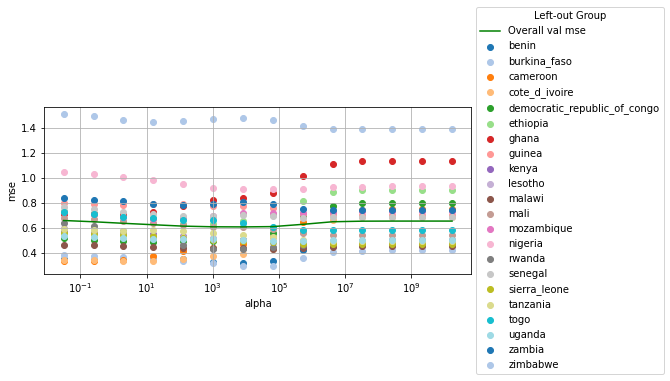

best val mse: 0.607, best alpha: 8192.0, test mse: 0.778
Group: benin
best val mse: 0.631, best alpha: 65536.0, test mse: 0.256
Group: burkina_faso
best val mse: 0.631, best alpha: 65536.0, test mse: 0.257
Group: cameroon


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.13882e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.0731e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.05283e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.00935e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=T

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.55776e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.62047e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.55481e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.53537e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.628, best alpha: 1024.0, test mse: 0.603
Group: cote_d_ivoire


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.00521e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.95575e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.94213e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.92571e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.619, best alpha: 8192.0, test mse: 0.345
Group: democratic_republic_of_congo


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.72282e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.58421e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.52953e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.56528e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.23792e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.28089e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.40631e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.25298e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.615, best alpha: 2.0, test mse: 0.516
Group: ethiopia


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.03249e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.97536e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.96054e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.94695e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.615, best alpha: 8192.0, test mse: 0.619
Group: ghana


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.17294e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.11832e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.09325e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.06678e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.59177e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.65764e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.5872e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.56895e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=T

best val mse: 0.621, best alpha: 65536.0, test mse: 0.879
Group: guinea
best val mse: 0.613, best alpha: 65536.0, test mse: 0.773
Group: kenya


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.58469e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.53598e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.49714e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.53539e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.611, best alpha: 0.25, test mse: 0.518
Group: lesotho


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.52344e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.47726e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.43974e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.47271e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.605, best alpha: 0.03125, test mse: 0.516
Group: malawi


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.2028e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.18304e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.14881e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.14577e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=T

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.72239e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.64834e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.62637e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.60847e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.647, best alpha: 65536.0, test mse: 0.455
Group: mali


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.99443e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.94219e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.92982e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.91859e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.614, best alpha: 8192.0, test mse: 0.627
Group: mozambique


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.81032e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.6695e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.60989e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.64897e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=T

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.33373e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.51247e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.34854e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.30723e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.604, best alpha: 2.0, test mse: 0.794
Group: nigeria


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.92102e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.76627e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.70621e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.743e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=Tr

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.46673e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.51247e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.47903e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.43787e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.585, best alpha: 2.0, test mse: 0.951
Group: rwanda


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.98471e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.93562e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.92443e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.91132e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.624, best alpha: 8192.0, test mse: 0.435
Group: senegal


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.53151e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.48821e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.45127e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.48341e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.596, best alpha: 0.25, test mse: 0.760
Group: sierra_leone
best val mse: 0.618, best alpha: 65536.0, test mse: 0.510
Group: tanzania
best val mse: 0.621, best alpha: 65536.0, test mse: 0.556
Group: togo


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.72463e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.59089e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.53766e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.57095e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.24647e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.28944e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.41644e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.26016e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.612, best alpha: 2.0, test mse: 0.628
Group: uganda


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.77424e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.63467e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.57994e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.61265e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.29936e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.3442e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.47398e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.31544e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=T

best val mse: 0.617, best alpha: 2.0, test mse: 0.517
Group: zambia


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.56462e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.51681e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.46928e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.5143e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=T

best val mse: 0.592, best alpha: 0.03125, test mse: 0.837
Group: zimbabwe


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.11403e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.74947e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.06166e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.0668e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=T

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.58593e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.65068e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.58201e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.56338e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

best val mse: 0.591, best alpha: 65536.0, test mse: 1.470
saving test preds to: ./outputs/dhs_ooc/test_preds.npz
saving ridge_weights to: ./outputs/dhs_ooc/ridge_weights.npz


In [12]:
model_name = 'resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc','resnet_attn_pretrain224stride')
ridgecv_ooc_wrapper(model_name, savedir)

In [ ]:
model_name = 'resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_buildings','resnet_nl_b')
ridgecv_ooc_wrapper(model_name, savedir)

import numpy as np
np.__version__

In [ ]:
!pip install numpy==1.16

In [ ]:
import numpy as np
with np.load('/content/africa_poverty_clean/outputs/dhs_ooc/DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001/features.npz') as npz:
 for key in npz.values():
   print(key)

In [ ]:
!python --version

In [ ]:
npz['features']

In [ ]:
def ridgecv_ooc_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR,'dhs_ooc','ablation_study',model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        features = npz['features']
        #features=(features-np.mean(features))/np.std(features)
        #print(features[:10])
        for country in dataset_constants_buildings.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = features
            print(country)
    ridge_cv(features=features_dict,labels=labels,group_labels=country_labels,group_names=COUNTRIES,do_plot=False,savedir=savedir,save_weights=True,save_dict=dict(locs=locs))

model_name = 'resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', 'resnet_unifor_attn224stride140')
ridgecv_ooc_wrapper(model_name, savedir)

In [ ]:
model_name = 'resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', 'resnet_nl_custom')
ridgecv_ooc_wrapper(model_name, savedir)

### Concatenated RGB/MS + NL features

In [ ]:
def ridgecv_ooc_concat_wrapper(model_names, savedir: str) -> None:
    features_dict = {}
    for f in FOLDS:
        concat_features = []  # list of np.array, each shape [N, D_i]
        for model_name in model_names:
            model_dir = MODEL_DIRS[f'{model_name}_{f}']
            if model_name=='resnet_nl':
               npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', model_dir, 'features.npz')
            else:
                 npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', 'ablation_study',model_dir, 'features.npz')
            npz = load_npz(npz_path, check={'labels': labels})
            concat_features.append(npz['features'])
        concat_features = np.concatenate(concat_features, axis=1)  # shape [N, D_1 + ... + D_m]
        for country in dataset_constants_buildings.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = concat_features
    ridge_cv(features=features_dict,labels=labels,group_labels=country_labels,group_names=COUNTRIES,do_plot=False,savedir=savedir,save_weights=True,save_dict=dict(locs=locs))

Each of the following 2 cells make take ~3-4 hours each to run.

In [ ]:
model_names = ['resnet_ms', 'resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', 'resnet_nl_build_noattn')
ridgecv_ooc_concat_wrapper(model_names, savedir)

In [ ]:
model_names = ['resnet_rgb', 'resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', 'resnet_rgbnl_concat')
ridgecv_ooc_concat_wrapper(model_names, savedir)

## Incountry

In [13]:
def ridgecv_incountry_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_incountry', model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        features_dict[f] = npz['features']

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        verbose=True)

features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
features: dtype=float32, shape=(19477, 512)
preds: dtype=float32, shape=(19477,)
labels: dtype=float32, shape=(19477,)
locs: dtype=float32, shape=(19477, 2)
years: dtype=int32, shape=(19477,)
test_preds.npz
./outputs/dhs_incountry/r

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.54524e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.69031e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.39827e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.72986e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=

Alpha: 17179869184.0 (14/14)


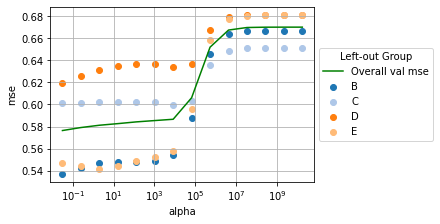

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.33579e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


best val mse: 0.576, best alpha: 0.03125, test mse: 0.590
Group: B
Alpha: 17179869184.0 (14/14)


/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.05337e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.84675e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


best val mse: 0.591, best alpha: 0.03125, test mse: 0.562
Group: C
Alpha: 0.03125 (1/14)

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.9187e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.83078e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.90577e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.572, best alpha: 2.0, test mse: 0.617
Group: D
Alpha: 0.03125 (1/14)

/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.92014e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.73492e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.61053e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/aimsg/PycharmProjects/demo/demo/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.8119e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=T

IndexError: index 4 is out of bounds for axis 1 with size 4

In [14]:
model_name = 'incountry_resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_incountry', 'resnet_ms')
ridgecv_incountry_wrapper(model_name, savedir)

In [ ]:
model_name = 'incountry_resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_incountry', 'resnet_nl')
ridgecv_incountry_wrapper(model_name, savedir)

### Concatenated MS + NL Features

In [ ]:
def ridgecv_incountry_concat_wrapper(model_names: Iterable[str], savedir: str) -> None:
    '''
    Args
    - model_names: list of str, correspond to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for i, f in enumerate(FOLDS):
        concat_features = []  # list of np.array, each shape [N, D_i]
        for model_name in model_names:
            model_dir = MODEL_DIRS[f'{model_name}_{f}']
            npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_incountry', model_dir, 'features.npz')
            npz = load_npz(npz_path, check={'labels': labels})
            concat_features.append(npz['features'])
        concat_features = np.concatenate(concat_features, axis=1)  # shape [N, D_1 + ... + D_m]
        features_dict[f] = concat_features

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        verbose=True)

In [ ]:
model_names = ['incountry_resnet_ms', 'incountry_resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_incountry', 'resnet_msnl_concat')
ridgecv_incountry_concat_wrapper(model_names, savedir)

### Transfer

In [ ]:
def ridgecv_incountry_transfer_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    model_dir = MODEL_DIRS[model_name]
    npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', model_dir, 'features.npz')
    features = load_npz(npz_path, check={'labels': labels})['features']
    ridge_cv(
        features=features,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=False)

In [ ]:
model_name = 'transfer_resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', MODEL_DIRS[model_name])
ridgecv_incountry_transfer_wrapper(model_name, savedir)

In [ ]:
model_name = 'transfer_resnet_rgb'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', MODEL_DIRS[model_name])
ridgecv_incountry_transfer_wrapper(model_name, savedir)

#Github

In [ ]:
%cd '/content/africa_poverty_clean'

In [ ]:
!git init

In [ ]:
!git config --global user.name 'AMNAALMGLY'

In [ ]:
!git config --global user.email 'mnmnalmagly@gmail.com'

In [ ]:
!git add .

In [ ]:
!git commit -m 'Amna'